In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.nn.functional as F
from collections import defaultdict
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from dataset import CustomImageDataset
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [2]:
os.cpu_count()

8

In [3]:
root_folder = "Indian_bovine_breeds"  # change this to your dataset path

class_counts = {}
for class_folder in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_folder)
    if os.path.isdir(class_path):
        num_files = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        class_counts[class_folder] = num_files
print(class_counts)

{'Vechur': 140, 'Mehsana': 95, 'Hallikar': 186, 'Amritmahal': 94, 'Kankrej': 179, 'Sahiwal': 439, 'Surti': 64, 'Jersey': 203, 'Pulikulam': 125, 'Nagpuri': 187, 'Nagori': 89, 'Malnad_gidda': 107, 'Dangi': 82, 'Murrah': 173, 'Jaffrabadi': 102, 'Red_Dane': 167, 'Krishna_Valley': 136, 'Guernsey': 119, 'Kherigarh': 36, 'Rathi': 149, 'Khillari': 113, 'Bargur': 94, 'Banni': 109, 'Holstein_Friesian': 328, 'Toda': 124, 'Alambadi': 99, 'Deoni': 99, 'Kangayam': 91, 'Kenkatha': 55, 'Kasargod': 95, 'Nimari': 84, 'Tharparkar': 217, 'Bhadawari': 86, 'Ongole': 191, 'Red_Sindhi': 166, 'Hariana': 130, 'Umblachery': 76, 'Gir': 372, 'Ayrshire': 234, 'Brown_Swiss': 225, 'Nili_Ravi': 89}


In [4]:
sorted_class_counts = [[k,v] for k,v in class_counts.items()]
sorted_class_counts = sorted(sorted_class_counts, key=lambda x: x[1], reverse=True)
sorted_class_counts

[['Sahiwal', 439],
 ['Gir', 372],
 ['Holstein_Friesian', 328],
 ['Ayrshire', 234],
 ['Brown_Swiss', 225],
 ['Tharparkar', 217],
 ['Jersey', 203],
 ['Ongole', 191],
 ['Nagpuri', 187],
 ['Hallikar', 186],
 ['Kankrej', 179],
 ['Murrah', 173],
 ['Red_Dane', 167],
 ['Red_Sindhi', 166],
 ['Rathi', 149],
 ['Vechur', 140],
 ['Krishna_Valley', 136],
 ['Hariana', 130],
 ['Pulikulam', 125],
 ['Toda', 124],
 ['Guernsey', 119],
 ['Khillari', 113],
 ['Banni', 109],
 ['Malnad_gidda', 107],
 ['Jaffrabadi', 102],
 ['Alambadi', 99],
 ['Deoni', 99],
 ['Mehsana', 95],
 ['Kasargod', 95],
 ['Amritmahal', 94],
 ['Bargur', 94],
 ['Kangayam', 91],
 ['Nagori', 89],
 ['Nili_Ravi', 89],
 ['Bhadawari', 86],
 ['Nimari', 84],
 ['Dangi', 82],
 ['Umblachery', 76],
 ['Surti', 64],
 ['Kenkatha', 55],
 ['Kherigarh', 36]]

In [5]:
def split_dataset_paths(root_folder, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=1337):
    np.random.seed(seed)
    dataset_splits = {}

    for cls in sorted(os.listdir(root_folder)):
        cls_path = os.path.join(root_folder, cls)
        if not os.path.isdir(cls_path):
            continue
        images = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        np.random.shuffle(images)

        n_total = len(images)
        # n_train = int(n_total * train_ratio)
        n_val = max(int(n_total * val_ratio), 5)
        n_test = max(int(n_total * test_ratio), 5)
        n_train = n_total - n_val - n_test

        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        dataset_splits[cls] = {
            'train': train_files,
            'val': val_files,
            'test': test_files
        }

    return dataset_splits

In [6]:
dataset = split_dataset_paths("Indian_bovine_breeds")

In [7]:
len(dataset['Kherigarh']['train']),len(dataset['Kherigarh']['val']),len(dataset['Kherigarh']['test'])

(26, 5, 5)

In [8]:
len(dataset['Sahiwal']['train']),len(dataset['Sahiwal']['val']),len(dataset['Sahiwal']['test'])

(353, 43, 43)

In [9]:
def create_file_list(splits_dict, split_name):
    file_list = []
    for cls, splits in splits_dict.items():
        label = list(splits_dict.keys()).index(cls)  # index of class
        paths = splits[split_name]
        file_list.extend([(p, label) for p in paths])
    return file_list

# Define torchvision transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class BalancedBatchSampler(Sampler):
    def __init__(self, labels, samples_per_class=5):
        """
        labels: list or array of class labels aligned with dataset indices
        samples_per_class: number of images per class per batch
        """
        self.labels = np.array(labels)
        self.samples_per_class = samples_per_class
        
        # Group indices by class
        self.class_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.class_indices[label].append(idx)
        
        # Calculate number of batches
        self.batches_per_epoch = min(len(idxs) // samples_per_class for idxs in self.class_indices.values())
        self.classes = list(self.class_indices.keys())

    def __iter__(self):
        batch = []
        # Shuffle indices within each class
        shuffled_indices = {}
        for c in self.classes:
            idxs = self.class_indices[c]
            np.random.shuffle(idxs)
            shuffled_indices[c] = idxs
        
        for batch_idx in range(self.batches_per_epoch):
            batch.clear()
            for c in self.classes:
                start = batch_idx * self.samples_per_class
                end = start + self.samples_per_class
                batch.extend(shuffled_indices[c][start:end])
            np.random.shuffle(batch)  # Optional: shuffle final batch indices
            yield batch

    def __len__(self):
        return self.batches_per_epoch

In [10]:
train_files = create_file_list(dataset, 'train')
val_files = create_file_list(dataset, 'val')
test_files = create_file_list(dataset, 'test')

train_dataset = CustomImageDataset(train_files, transform=transform)
val_dataset = CustomImageDataset(val_files, transform=transform)
test_dataset = CustomImageDataset(test_files, transform=transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    prefetch_factor=2,
    pin_memory=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    prefetch_factor=2,
    pin_memory=True,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    prefetch_factor=2,
    pin_memory=True,
    num_workers=2
)

In [11]:
train_files = create_file_list(dataset, 'train')  # as before
train_labels = [label for _, label in train_files]

train_dataset = CustomImageDataset(train_files, transform=transform)
train_sampler = BalancedBatchSampler(train_labels, samples_per_class=1)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_files = create_file_list(dataset, 'val')  # as before
val_labels = [label for _, label in val_files]

val_dataset = CustomImageDataset(val_files, transform=transform)
val_sampler = BalancedBatchSampler(val_labels, samples_per_class=3)
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler)

test_files = create_file_list(dataset, 'test')  # as before
test_labels = [label for _, label in test_files]

test_dataset = CustomImageDataset(test_files, transform=transform)
test_sampler = BalancedBatchSampler(test_labels, samples_per_class=3)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

In [12]:
len(train_loader), len(val_loader), len(test_loader)

(26, 1, 1)

In [13]:
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             # nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             # nn.Conv2d(64, 64, kernel_size=3, padding=1),            
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             # nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             # nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 28 * 28, 256),  # assuming input size 224x224
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

In [14]:
# def train(model, train_loader, val_loader, epochs=10, lr=0.001, device='cuda'):
#     model = model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in tqdm(train_loader):
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         train_loss = running_loss / total
#         train_acc = correct / total

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         val_correct = 0
#         val_total = 0
#         with torch.no_grad():
#             for images, labels in tqdm(val_loader):
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * images.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (predicted == labels).sum().item()

#         val_loss /= val_total
#         val_acc = val_correct / val_total

#         print(f"Epoch [{epoch + 1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

In [15]:
# num_classes = 41  # number of classes
# model = SimpleCNN(num_classes)
# train(model, train_loader, val_loader, epochs=10, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Episodic Sampler for N-way K-shot + Q query setup
class EpisodicBatchSampler(Sampler):
    def __init__(self, labels, n_way, k_shot, episodes_per_epoch):
        self.labels = np.array(labels)
        self.n_way = n_way
        self.k_shot = k_shot
        self.episodes_per_epoch = episodes_per_epoch

        self.class_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.class_to_indices[label].append(idx)

        # only keep classes with enough samples
        self.classes = [c for c in self.class_to_indices if len(self.class_to_indices[c]) >= k_shot]

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch_indices = []
            selected_classes = np.random.choice(self.classes, self.n_way, replace=False)
            for cls in selected_classes:
                indices = np.random.choice(self.class_to_indices[cls], self.k_shot, replace=False)
                batch_indices.extend(indices)
            yield batch_indices

# Simple CNN embedding model
class ProtoNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super(ProtoNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)  # halve spatial resolution
            )

        # 224 → 112 → 56 → 28 → 14 → 7
        self.encoder = nn.Sequential(
            conv_block(3, 4),      # 224 → 112
            conv_block(4, 8),    # 112 → 56
            conv_block(8, 16),   # 56 → 28
            conv_block(16, 32),   # 28 → 14
            conv_block(32, embedding_dim),  # 14 → 7
            nn.AdaptiveAvgPool2d(1) # always → (1,1)
        )

    def forward(self, x):
        x = self.encoder(x)              # (B, embedding_dim, 1, 1)
        return x.view(x.size(0), -1)     # flatten → (B, embedding_dim)

        
# Prototypical loss function
def prototypical_loss(embeddings, targets, n_way, k_shot, q_query):
    """
    embeddings: (batch_size, embedding_dim) for one episode
    targets: (batch_size) class labels, mapped 0 to n_way-1 for sampled classes
    """
    support_indices = []
    query_indices = []
    for i in range(n_way):
        support_indices.extend(range(i*(k_shot+q_query), i*(k_shot+q_query) + k_shot))
        query_indices.extend(range(i*(k_shot+q_query) + k_shot, (i+1)*(k_shot+q_query)))
    support_embeddings = embeddings[support_indices]
    query_embeddings = embeddings[query_indices]

    # compute prototypes
    prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # (n_way, embedding_dim)

    # dist between queries and prototypes (batch matrix)
    dists = torch.cdist(query_embeddings, prototypes)  # (n_way*q_query, n_way)

    # Compute log-probabilities
    log_p_y = F.log_softmax(-dists, dim=1)  # negative distances as logits

    # Construct query labels
    query_labels = torch.arange(n_way).unsqueeze(1).repeat(1, q_query).view(-1).to(embeddings.device)

    # Loss is negative log-likelihood of true classes
    loss = F.nll_loss(log_p_y, query_labels)

    # Accuracy
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, query_labels).float().mean()

    return loss, acc

# Transforms
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])

# Train / Val / Test splits
train_files = create_file_list(dataset, 'train')
train_labels = [label for _, label in train_files]

val_files = create_file_list(dataset, 'val')
val_labels = [label for _, label in val_files]

test_files = create_file_list(dataset, 'test')
test_labels = [label for _, label in test_files]

# Parameters
n_way = 41
k_shot = 4          
episodes_per_epoch = 100

# Datasets
train_dataset = CustomImageDataset(train_files, transform=transform)
val_dataset   = CustomImageDataset(val_files, transform=transform)

# Samplers
train_sampler = EpisodicBatchSampler(train_labels, n_way, k_shot, episodes_per_epoch)
# Parameters
n_way = 41
k_shot = 2          
episodes_per_epoch = 100
val_sampler   = EpisodicBatchSampler(val_labels,   n_way, k_shot, episodes_per_epoch)

# Loaders
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=8,
    prefetch_factor=1,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    num_workers=8,
    prefetch_factor=1,
    persistent_workers=True
)


In [17]:
if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = "mps"
else:
    device = "cpu"

print("Using device:", device)
model = ProtoNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# for epoch in range(10):
#     model.train()
#     total_loss, total_acc = 0.0, 0.0
#     for batch in tqdm(train_loader):
#         images, labels = batch
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         embeddings = model(images)

#         # Remap labels to 0..n_way-1 for the sampled classes within the episode
#         # This is necessary because batch includes only n_way classes but labels have global indices
#         unique_labels = torch.unique(labels)
#         label_map = {l.item(): i for i, l in enumerate(unique_labels)}
#         mapped_labels = torch.tensor([label_map[l.item()] for l in labels]).to(device)

#         loss, acc = prototypical_loss(embeddings, mapped_labels, n_way, k_shot, q_query)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         total_acc += acc.item()

#     print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Acc: {total_acc / len(train_loader):.4f}")

Using device: cpu


In [18]:
# # Before training loop
# class_prototypes = torch.zeros(41, 64, device=device)
# class_counts = torch.zeros(41, device=device)

# for epoch in range(20):
#     model.train()
#     total_loss, total_acc = 0.0, 0.0
#     class_correct = defaultdict(int)
#     class_total = defaultdict(int)

#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         images, labels = batch
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         embeddings = model(images)  # (B, embedding_dim)

#         # --- Compute distances to ALL prototypes ---
#         dists = torch.cdist(embeddings, class_prototypes)  # (B, num_classes)
#         logits = -dists

#         # --- Loss & optimization ---
#         loss = F.cross_entropy(logits, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         preds = logits.argmax(dim=1)
#         total_acc += (preds == labels).float().mean().item()

#         # --- Per-class accuracy tracking ---
#         for t, p in zip(labels, preds):
#             class_total[t.item()] += 1
#             if t == p:
#                 class_correct[t.item()] += 1

#         # --- Update prototypes safely ---
#         with torch.no_grad():
#             for c in labels.unique():
#                 emb = embeddings[labels == c].mean(dim=0).detach()
#                 count = (labels == c).sum()
#                 class_prototypes[c] = (class_prototypes[c] * class_counts[c] + emb * count) / (class_counts[c] + count)
#                 class_counts[c] += count

#     # --- End of epoch summary ---
#     avg_loss = total_loss / len(train_loader)
#     avg_acc = total_acc / len(train_loader)
#     print(f"\nEpoch {epoch + 1} Summary:")
#     print(f"  Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

#     print("  Per-class accuracy:")
#     for cls in range(41):
#         if class_total[cls] > 0:
#             acc_cls = class_correct[cls] / class_total[cls]
#             print(f"    Class {cls:02d}: {acc_cls:.4f} ({class_correct[cls]}/{class_total[cls]})")
#         else:
#             print(f"    Class {cls:02d}: N/A (not sampled this epoch)")


Train Epoch 1:  21%|██        | 21/100 [00:15<00:32,  2.46it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train Epoch 1:  38%|███▊      | 38/100 [00:22<00:24,  2.48it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train Epoch 1:  57%|█████▋    | 57/100 [00:29<00:16,  2.54it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train Epoch 1:  94%|█████████▍| 94/100 [00:44<00:02,  2.75it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Pale


Epoch 1 Summary:
  Train Loss: 3.6590, Train Acc: 0.0712
  Val   Loss: 3.6355, Val   Acc: 0.0672


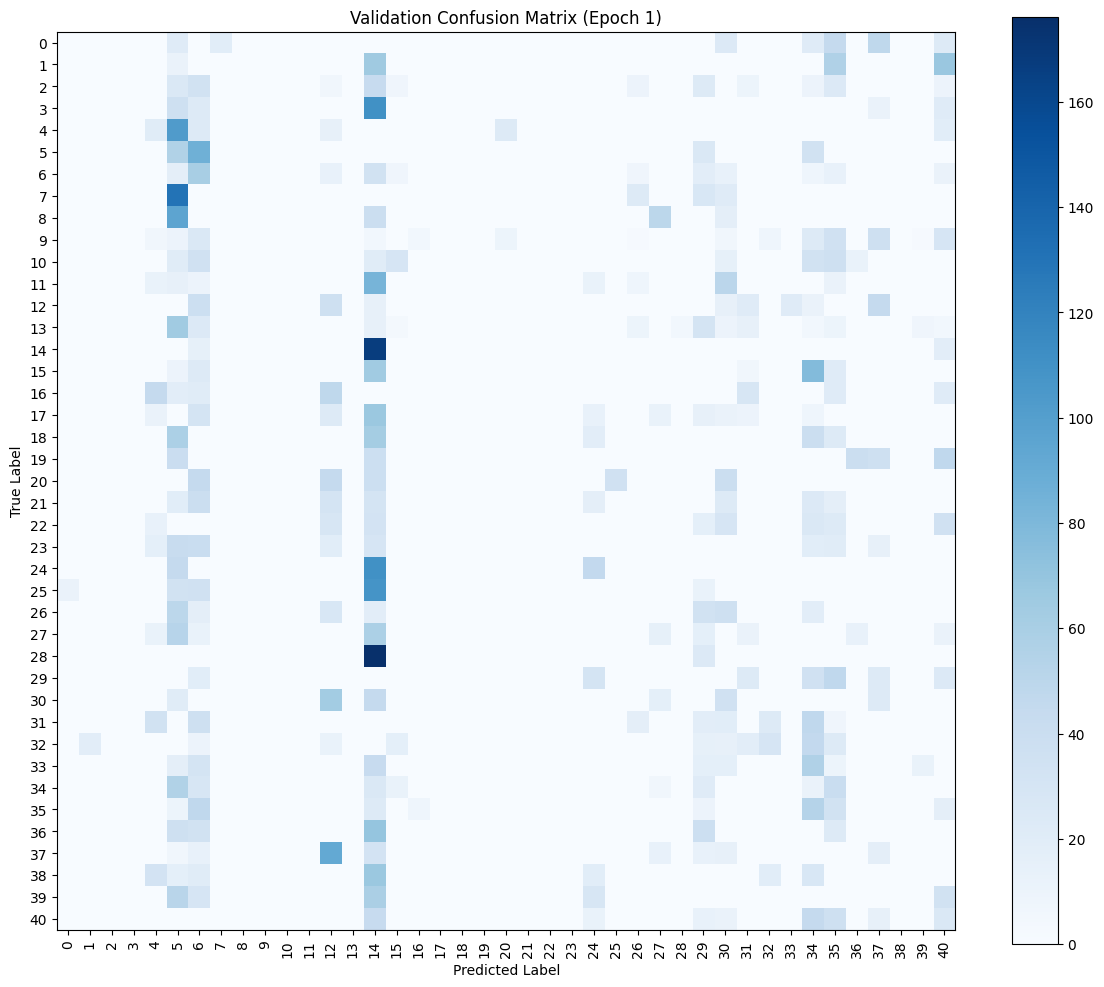

Train Epoch 2:  73%|███████▎  | 73/100 [00:30<00:10,  2.46it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val Epoch 2:  41%|████      | 41/100 [00:06<00:07,  7.72it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]



Epoch 2 Summary:
  Train Loss: 3.3805, Train Acc: 0.1364
  Val   Loss: 3.4919, Val   Acc: 0.0946


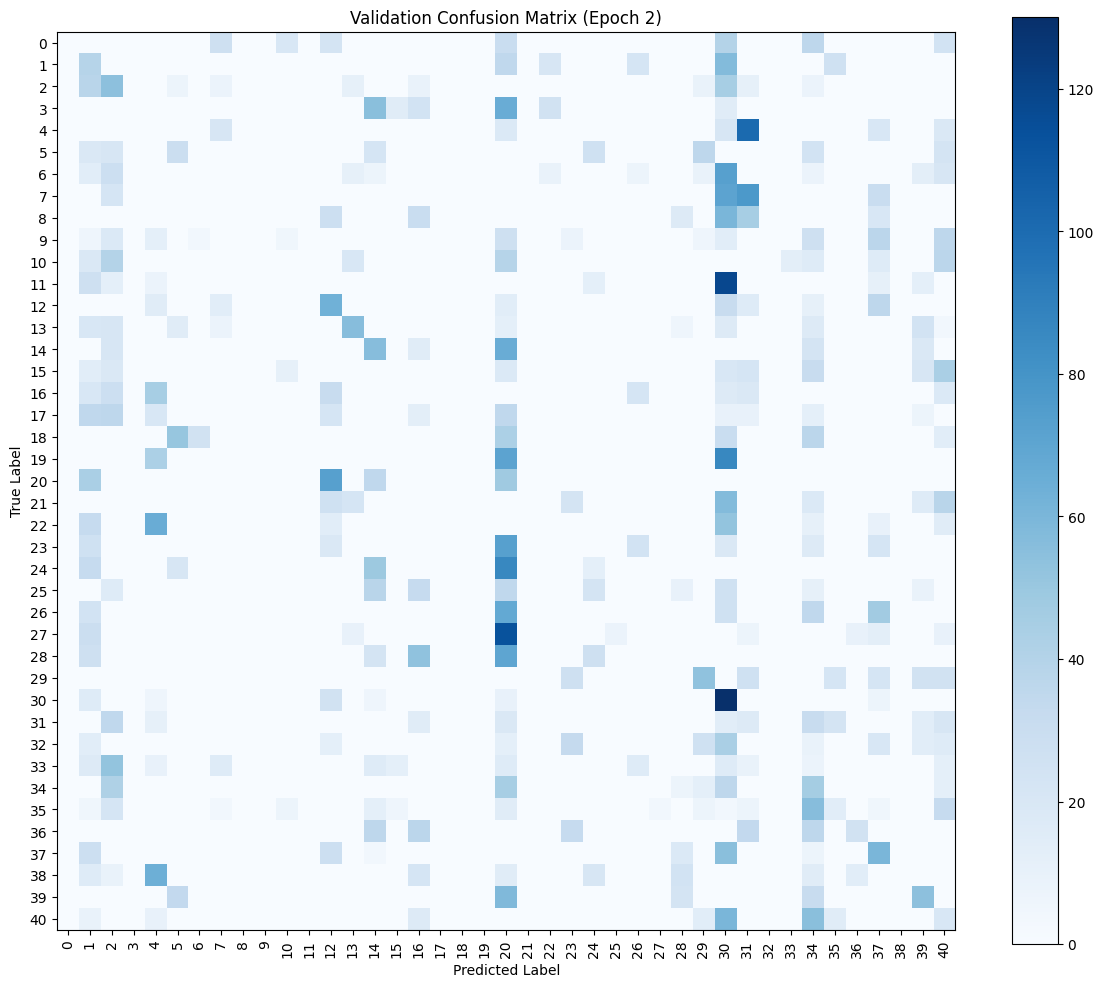

Train Epoch 3:  36%|███▌      | 36/100 [00:16<00:26,  2.46it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train Epoch 3:  79%|███████▉  | 79/100 [00:33<00:08,  2.47it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 3 Summary:
  Train Loss: 3.2230, Train Acc: 0.1813
  Val   Loss: 3.4179, Val   Acc: 0.0952


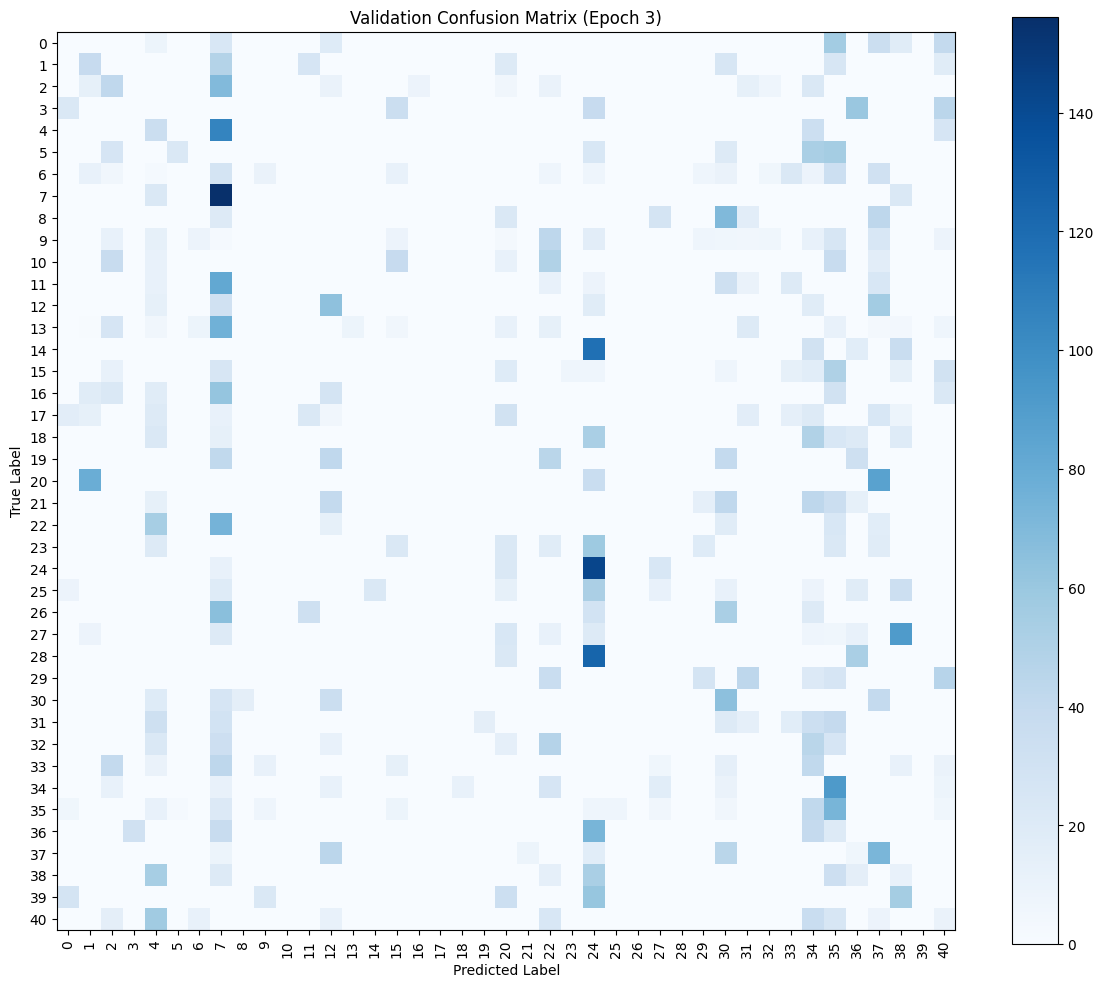

Val Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]



Epoch 4 Summary:
  Train Loss: 3.1069, Train Acc: 0.2141
  Val   Loss: 3.3518, Val   Acc: 0.1038


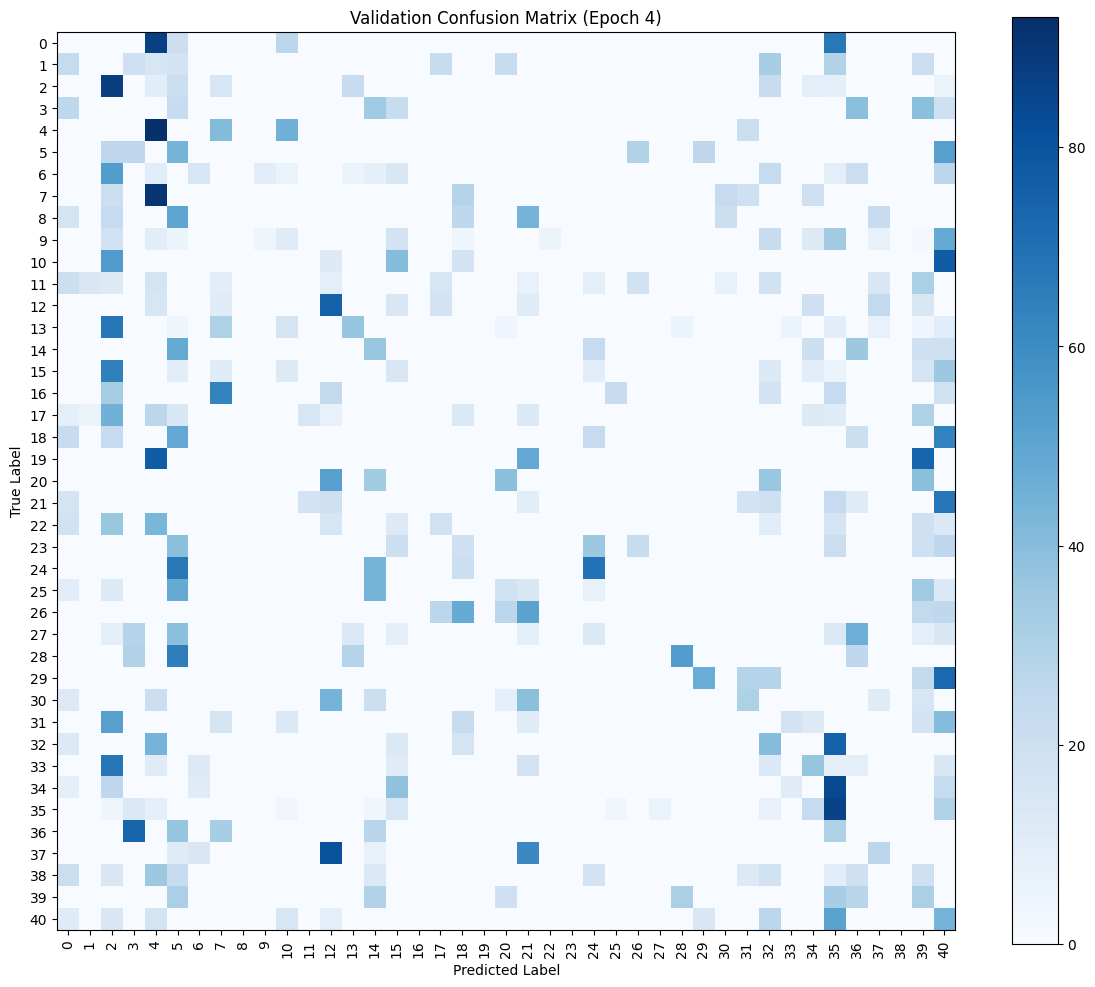

Val Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 5 Summary:
  Train Loss: 2.9994, Train Acc: 0.2524
  Val   Loss: 3.3443, Val   Acc: 0.1189


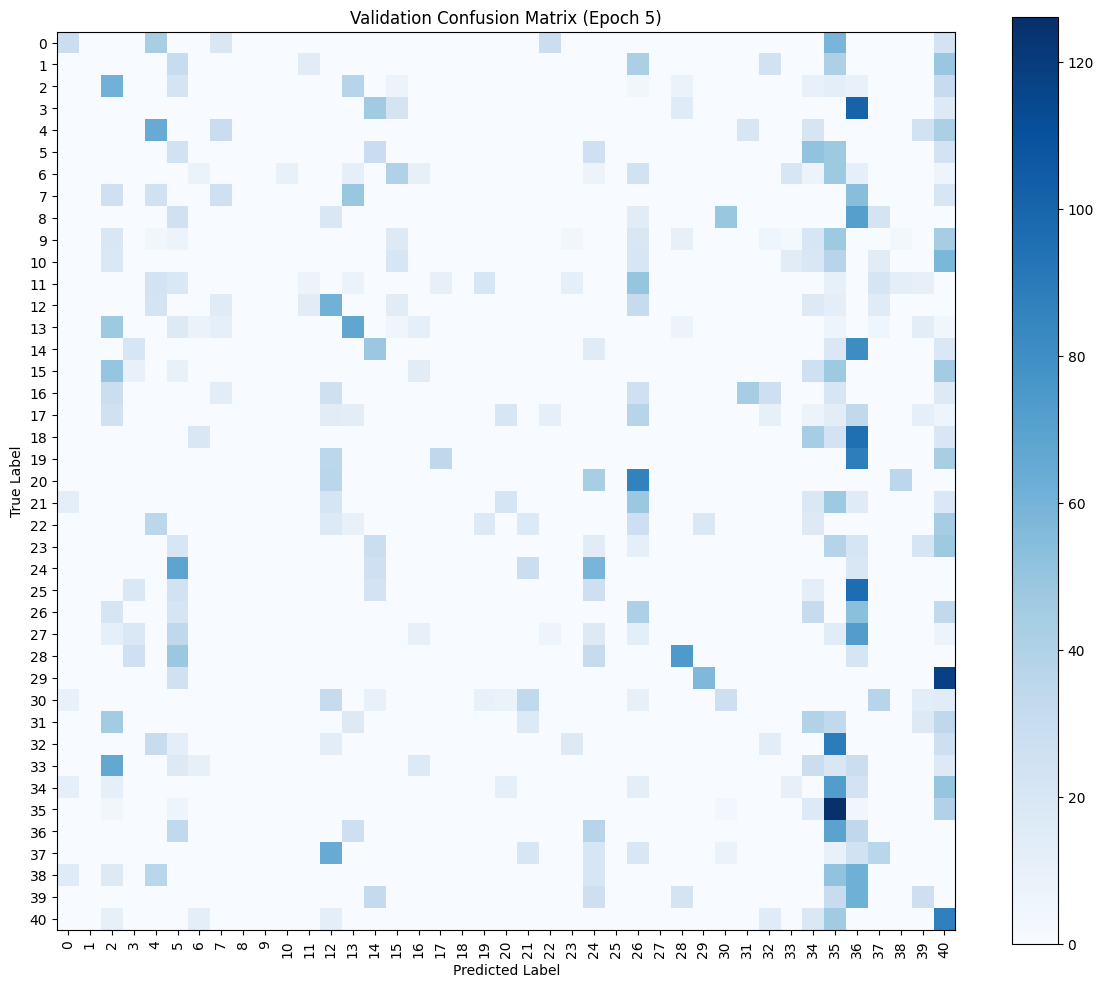

Val Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]



Epoch 6 Summary:
  Train Loss: 2.9072, Train Acc: 0.2846
  Val   Loss: 3.3212, Val   Acc: 0.1482


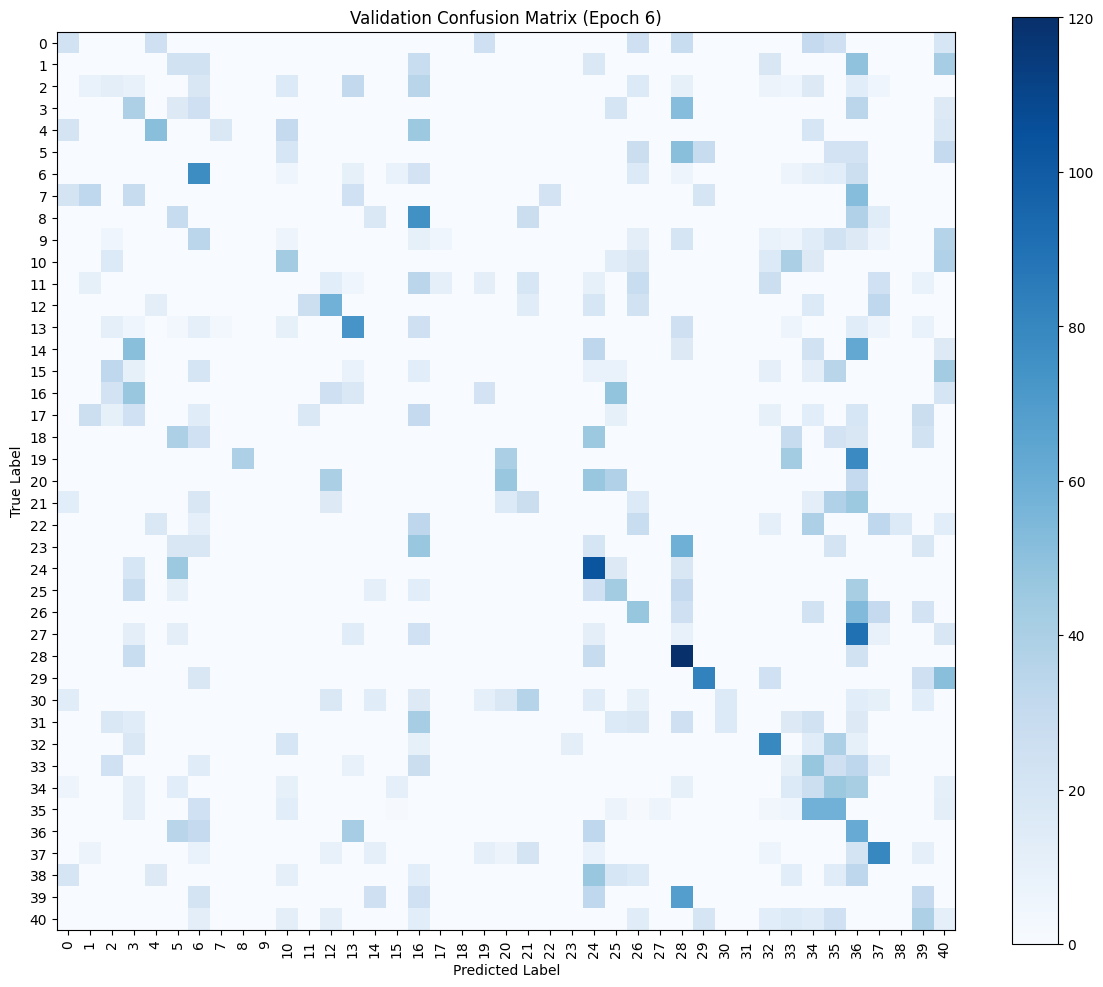

Train Epoch 7:  54%|█████▍    | 54/100 [00:23<00:18,  2.44it/s]/Users/fakiraaqilparvez/Documents/DQ 2.0/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]



Epoch 7 Summary:
  Train Loss: 2.8052, Train Acc: 0.3188
  Val   Loss: 3.2990, Val   Acc: 0.1183


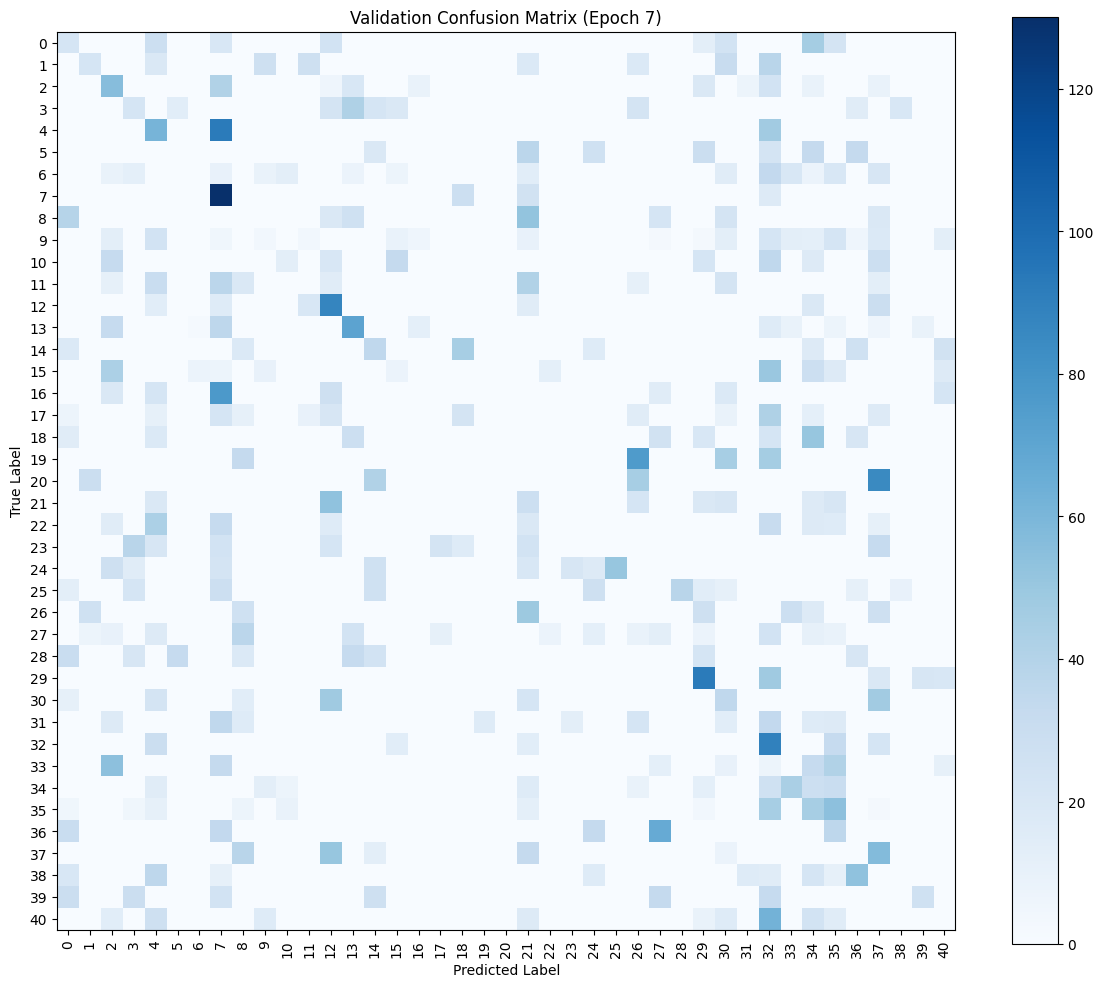

Val Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]



Epoch 8 Summary:
  Train Loss: 2.7303, Train Acc: 0.3410
  Val   Loss: 3.2298, Val   Acc: 0.1424


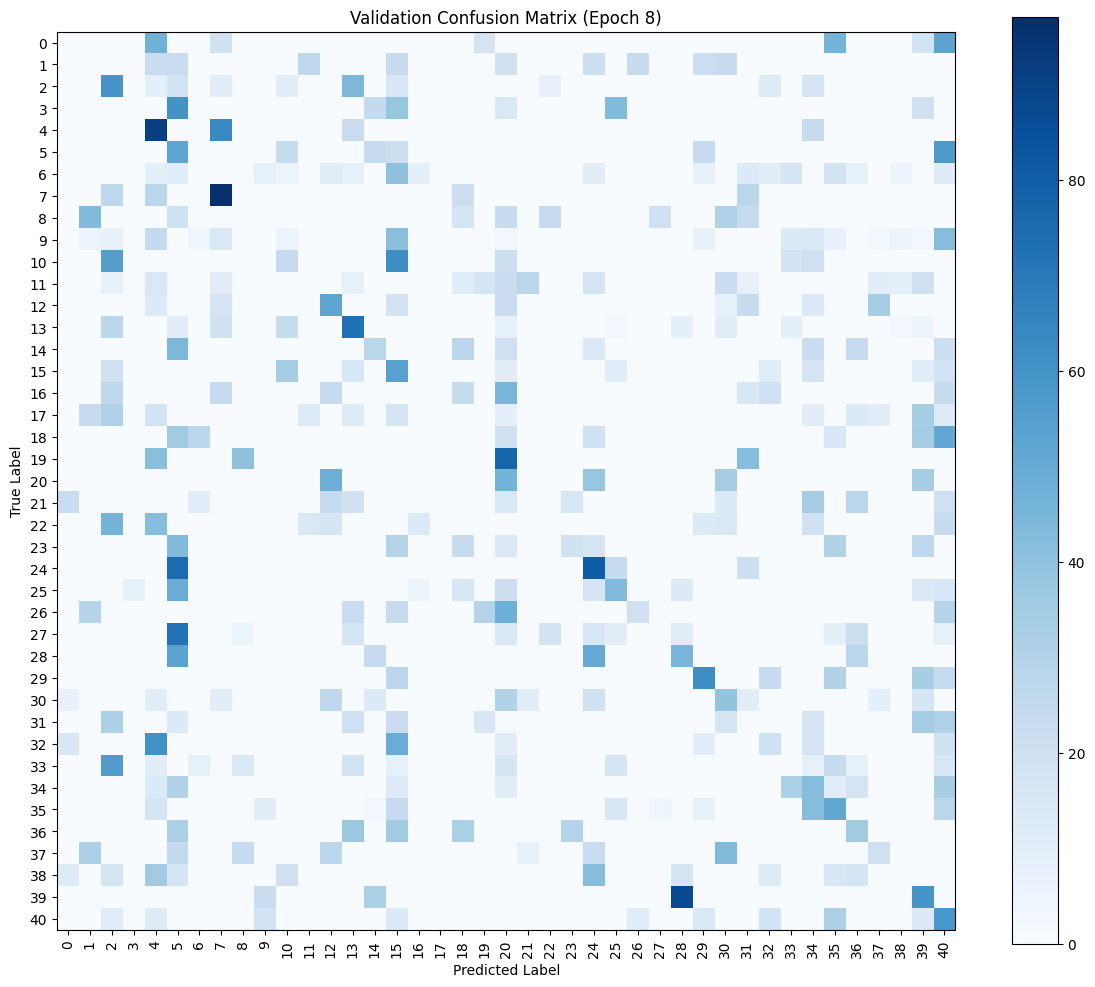

Val Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 9 Summary:
  Train Loss: 2.6728, Train Acc: 0.3589
  Val   Loss: 3.4877, Val   Acc: 0.0790


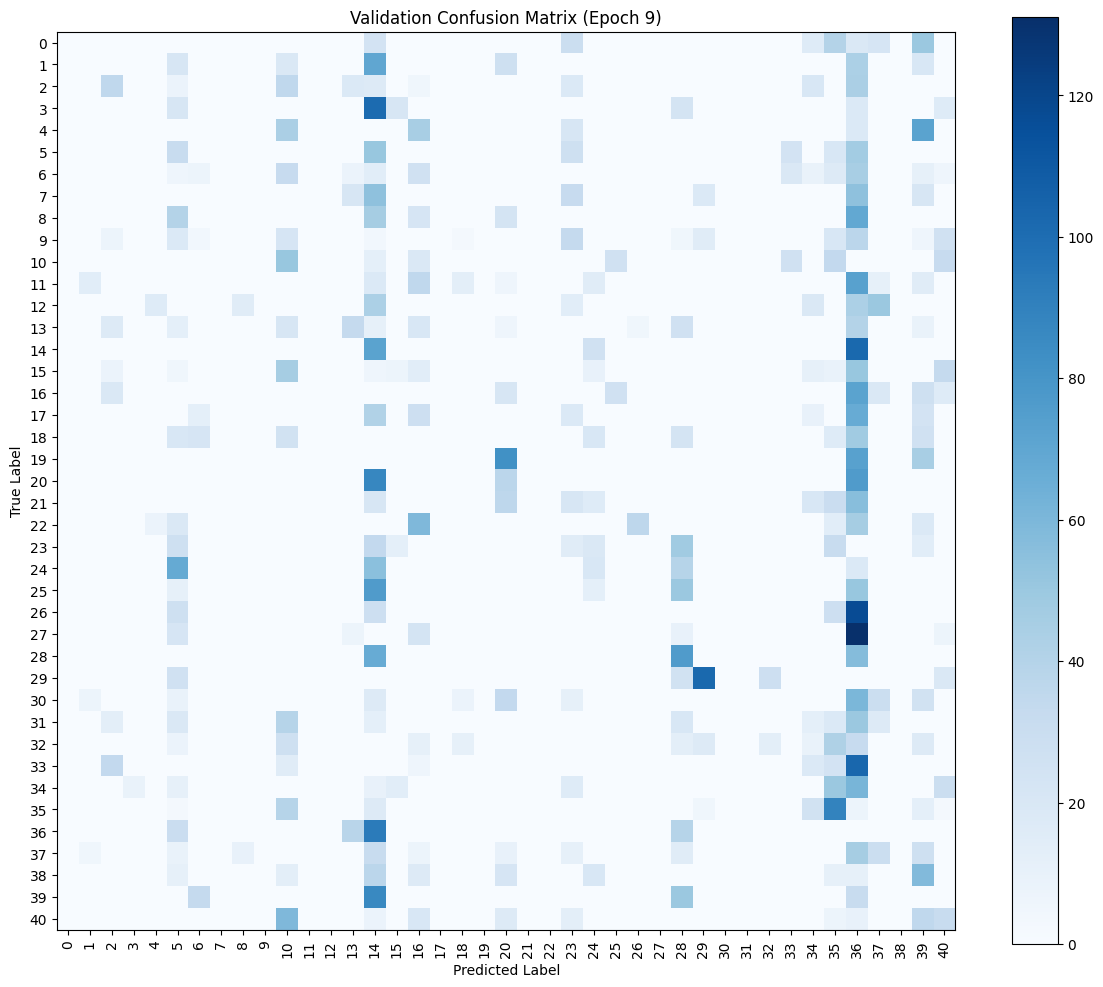

Val Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 10 Summary:
  Train Loss: 2.5915, Train Acc: 0.3854
  Val   Loss: 3.2161, Val   Acc: 0.1432


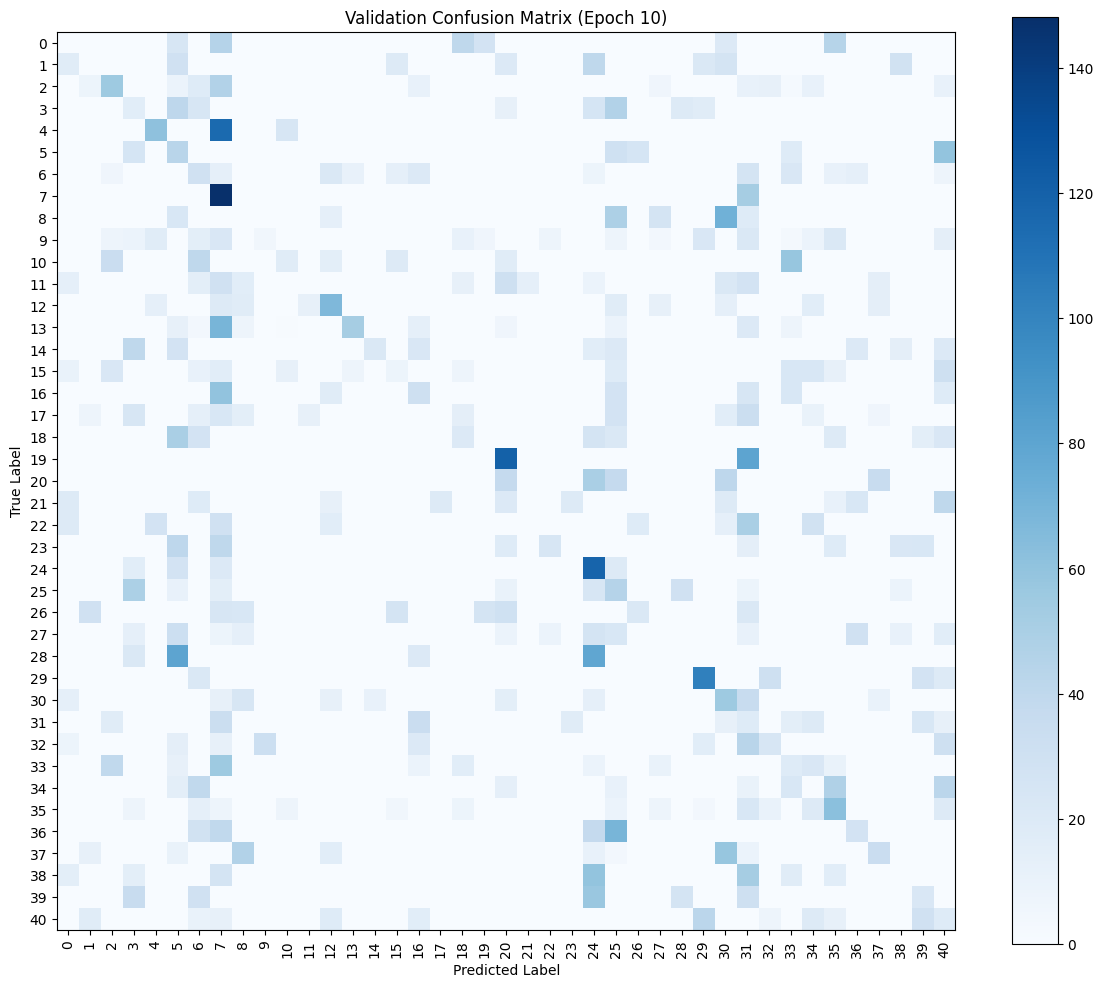


  Per-class Training Accuracy:
    Class 00: 0.4225 (169/400)
    Class 01: 0.3650 (146/400)
    Class 02: 0.3500 (140/400)
    Class 03: 0.4250 (170/400)
    Class 04: 0.8050 (322/400)
    Class 05: 0.4925 (197/400)
    Class 06: 0.2250 (90/400)
    Class 07: 0.8125 (325/400)
    Class 08: 0.4800 (192/400)
    Class 09: 0.0275 (11/400)
    Class 10: 0.3475 (139/400)
    Class 11: 0.1650 (66/400)
    Class 12: 0.5275 (211/400)
    Class 13: 0.6075 (243/400)
    Class 14: 0.4750 (190/400)
    Class 15: 0.2175 (87/400)
    Class 16: 0.2675 (107/400)
    Class 17: 0.0900 (36/400)
    Class 18: 0.2650 (106/400)
    Class 19: 0.3050 (122/400)
    Class 20: 0.9975 (399/400)
    Class 21: 0.4075 (163/400)
    Class 22: 0.0800 (32/400)
    Class 23: 0.3125 (125/400)
    Class 24: 0.6975 (279/400)
    Class 25: 0.1775 (71/400)
    Class 26: 0.3775 (151/400)
    Class 27: 0.0650 (26/400)
    Class 28: 0.4425 (177/400)
    Class 29: 0.5825 (233/400)
    Class 30: 0.3575 (143/400)
    Class 31: 0

Val Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]



Epoch 11 Summary:
  Train Loss: 2.5330, Train Acc: 0.3999
  Val   Loss: 3.3108, Val   Acc: 0.1341


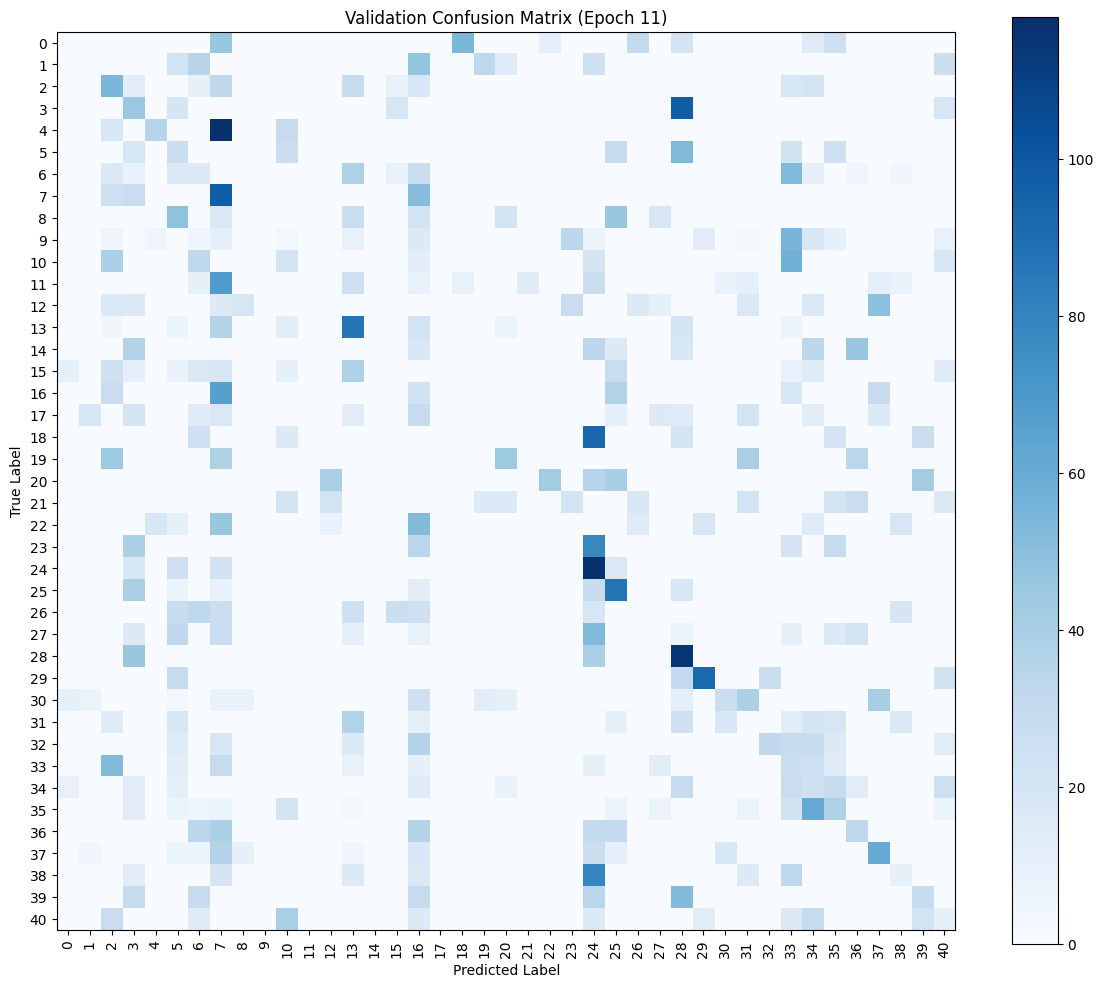

Val Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 12 Summary:
  Train Loss: 2.4682, Train Acc: 0.4216
  Val   Loss: 3.1966, Val   Acc: 0.1595


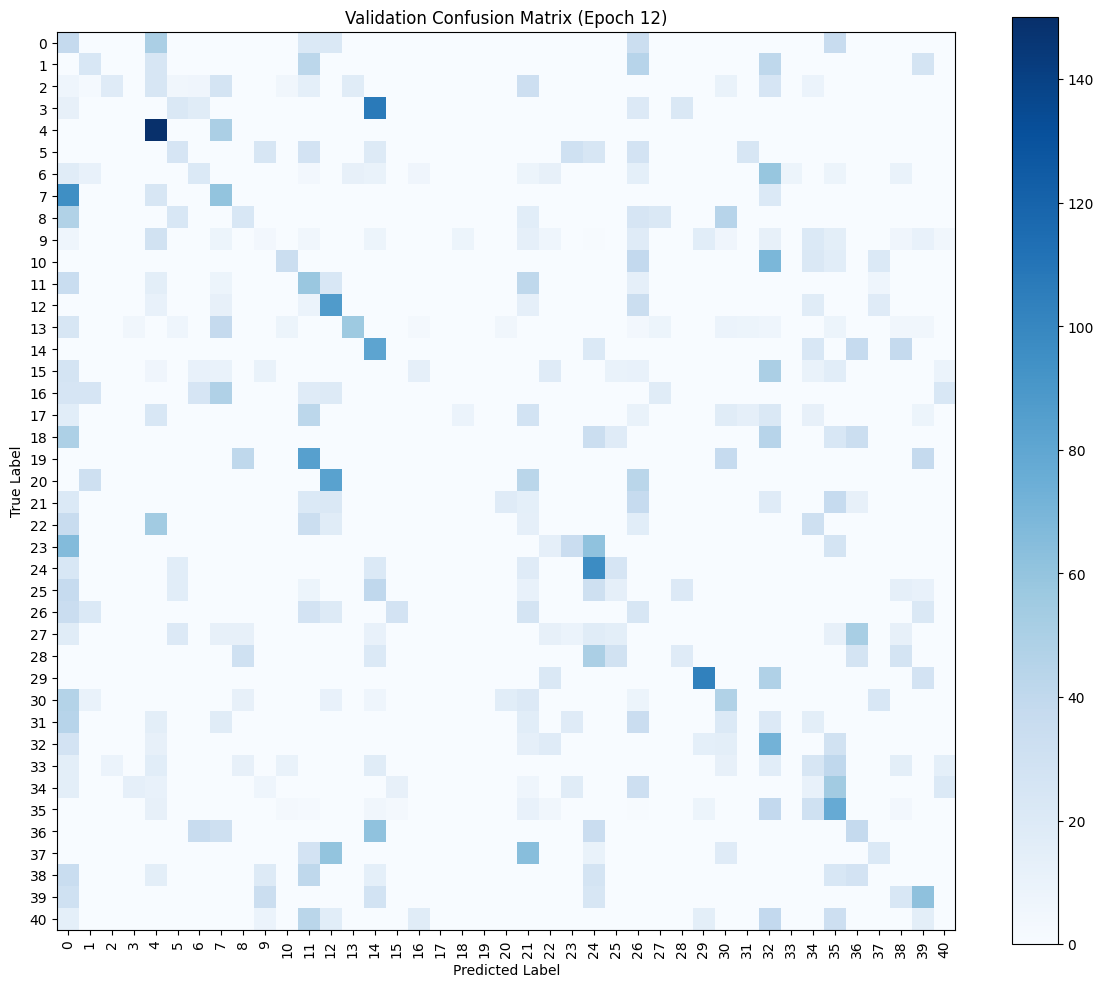

Val Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]



Epoch 13 Summary:
  Train Loss: 2.4156, Train Acc: 0.4341
  Val   Loss: 3.1827, Val   Acc: 0.1456


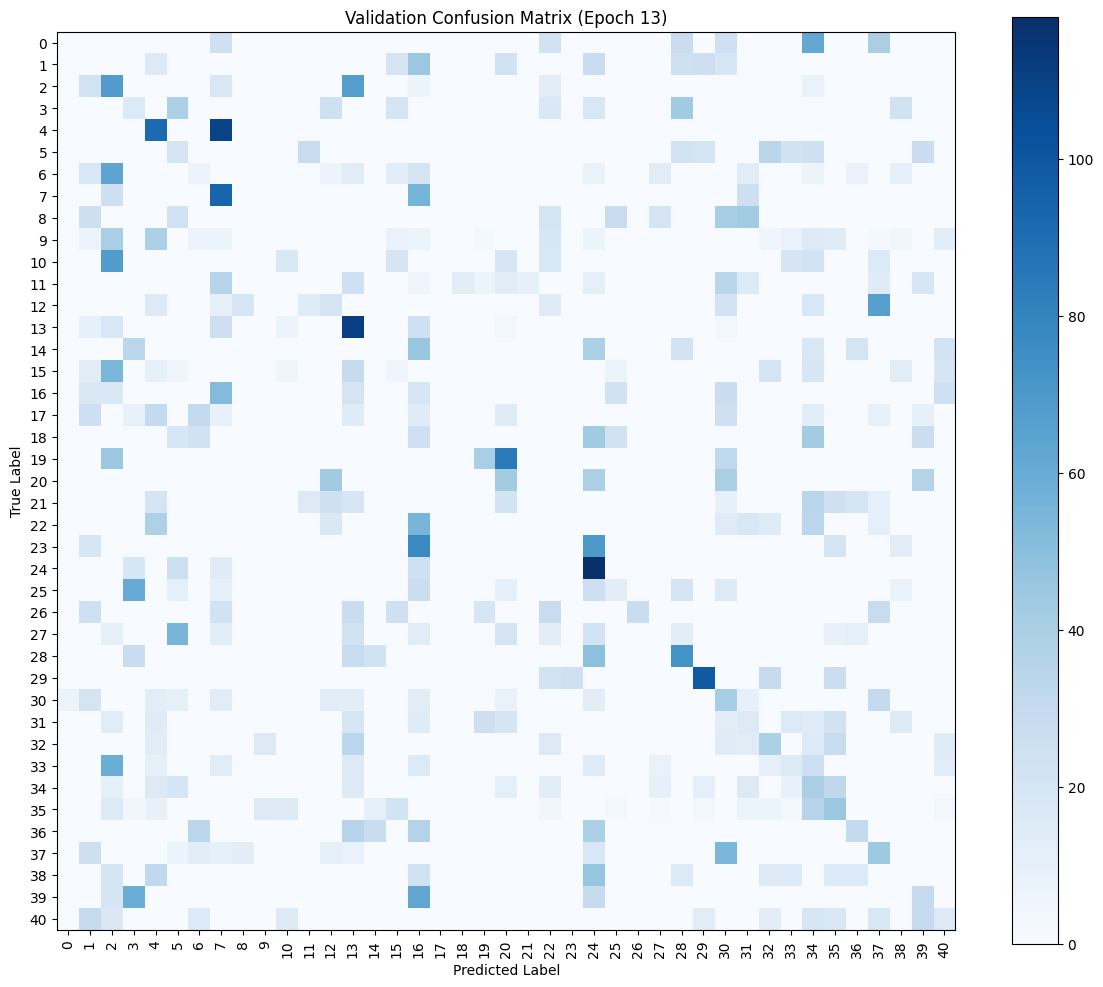

Val Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]



Epoch 14 Summary:
  Train Loss: 2.3645, Train Acc: 0.4491
  Val   Loss: 3.1516, Val   Acc: 0.1394


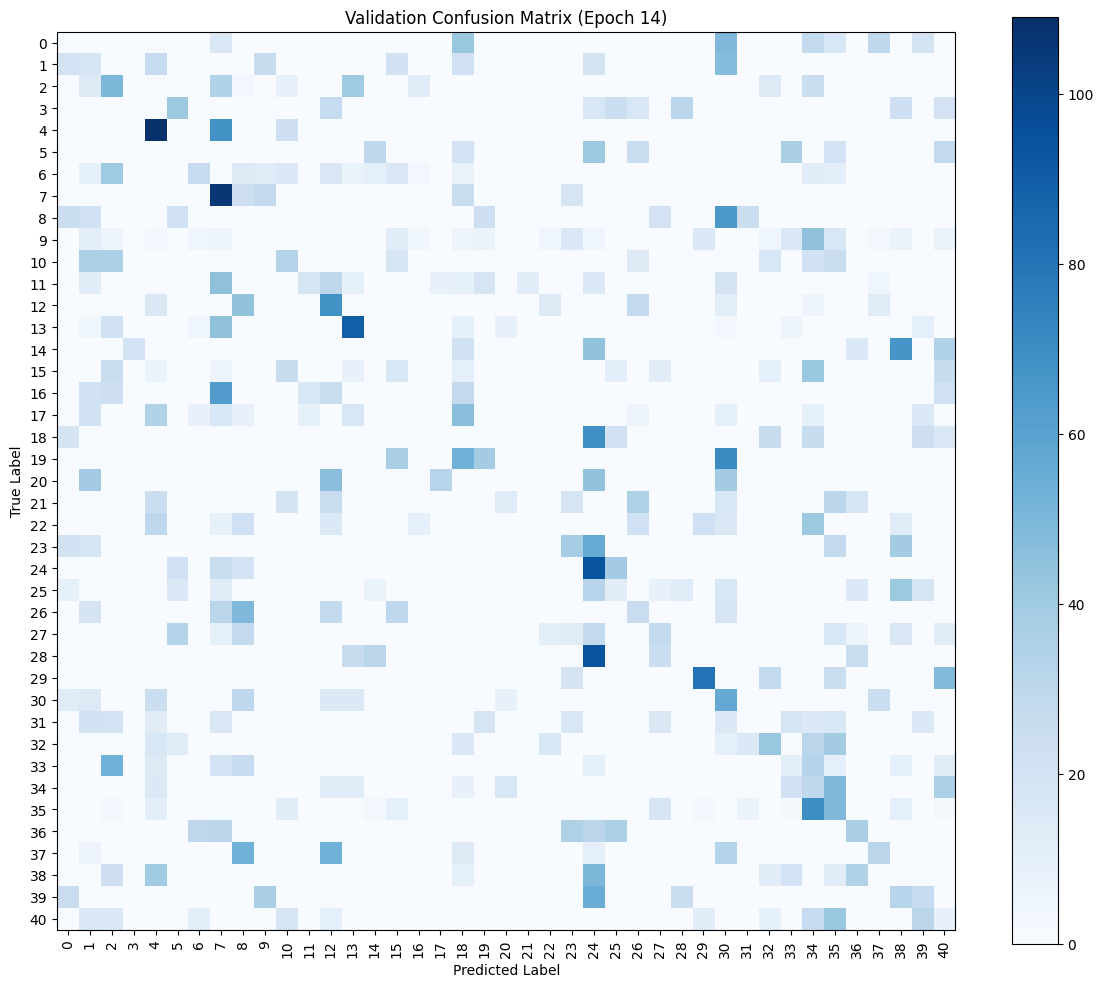

Val Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]



Epoch 15 Summary:
  Train Loss: 2.3026, Train Acc: 0.4677
  Val   Loss: 3.2202, Val   Acc: 0.1568


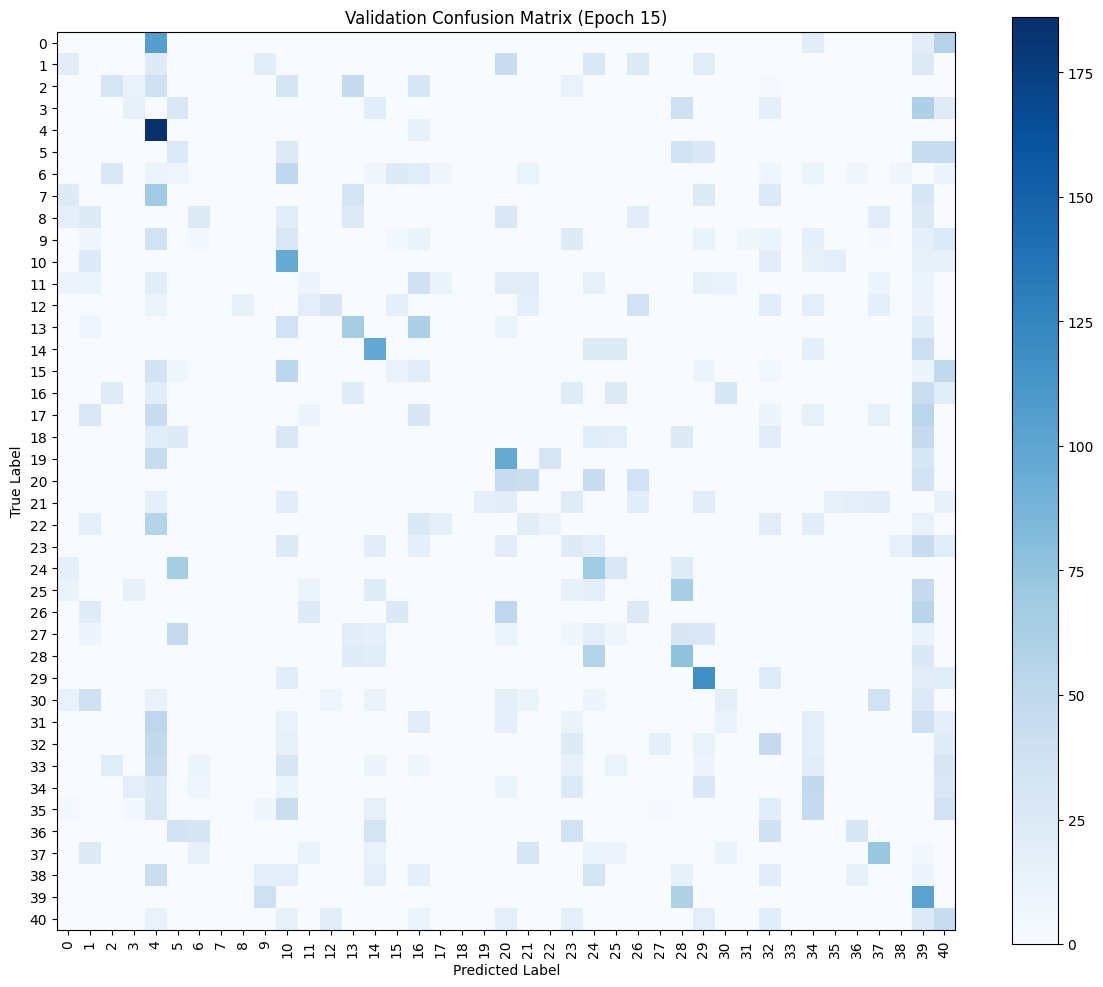

Val Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16 Summary:
  Train Loss: 2.2587, Train Acc: 0.4807
  Val   Loss: 3.1823, Val   Acc: 0.1441


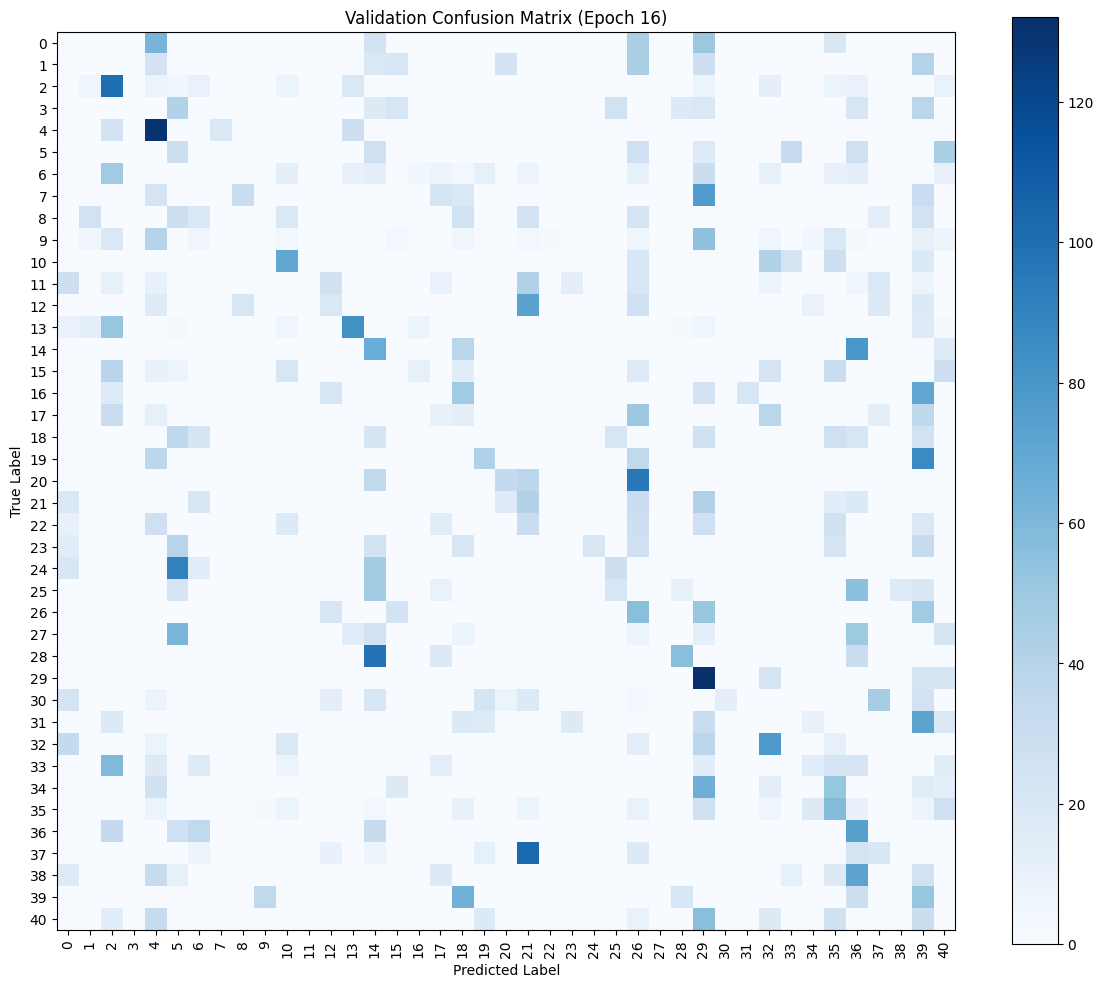

Val Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]



Epoch 17 Summary:
  Train Loss: 2.2101, Train Acc: 0.4909
  Val   Loss: 3.1469, Val   Acc: 0.1635


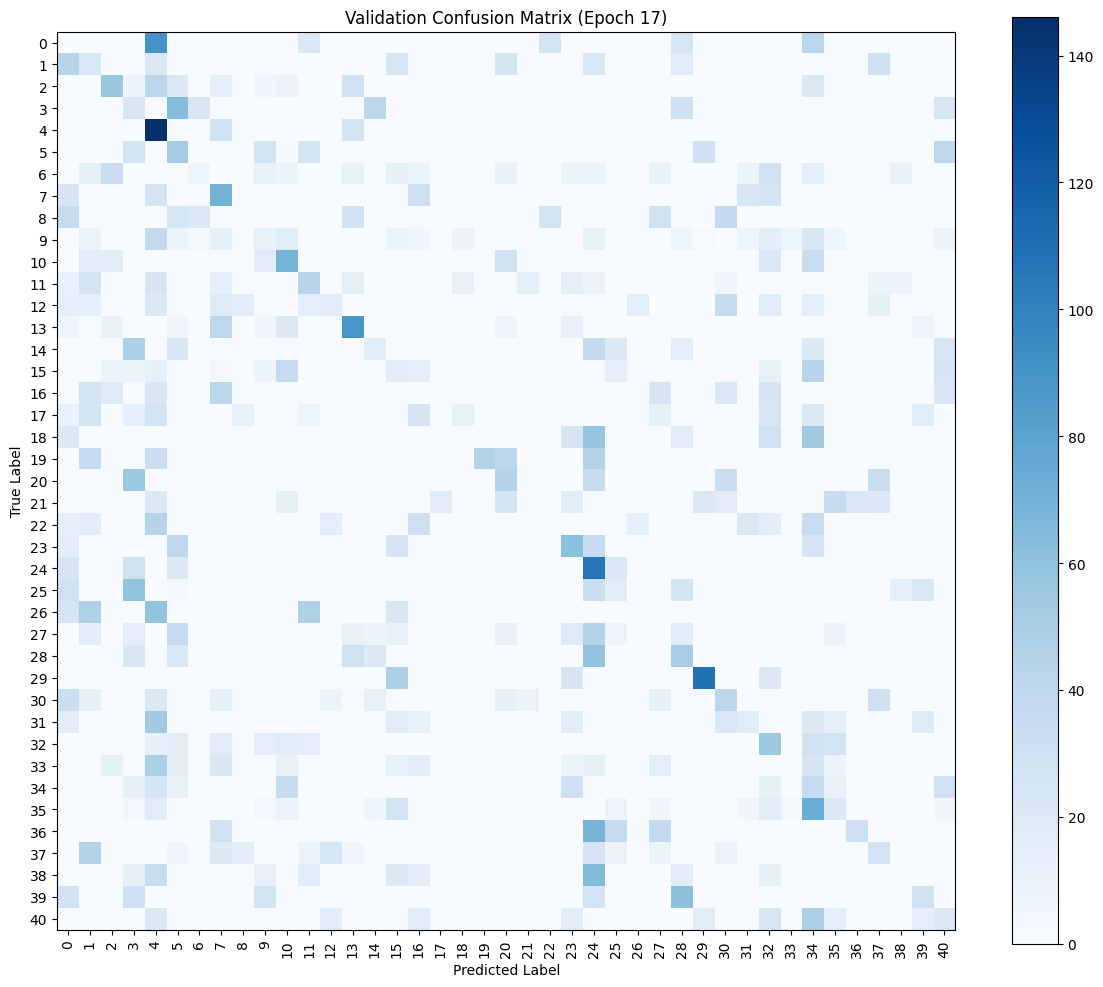

Val Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]



Epoch 18 Summary:
  Train Loss: 2.1743, Train Acc: 0.4987
  Val   Loss: 3.1268, Val   Acc: 0.1595


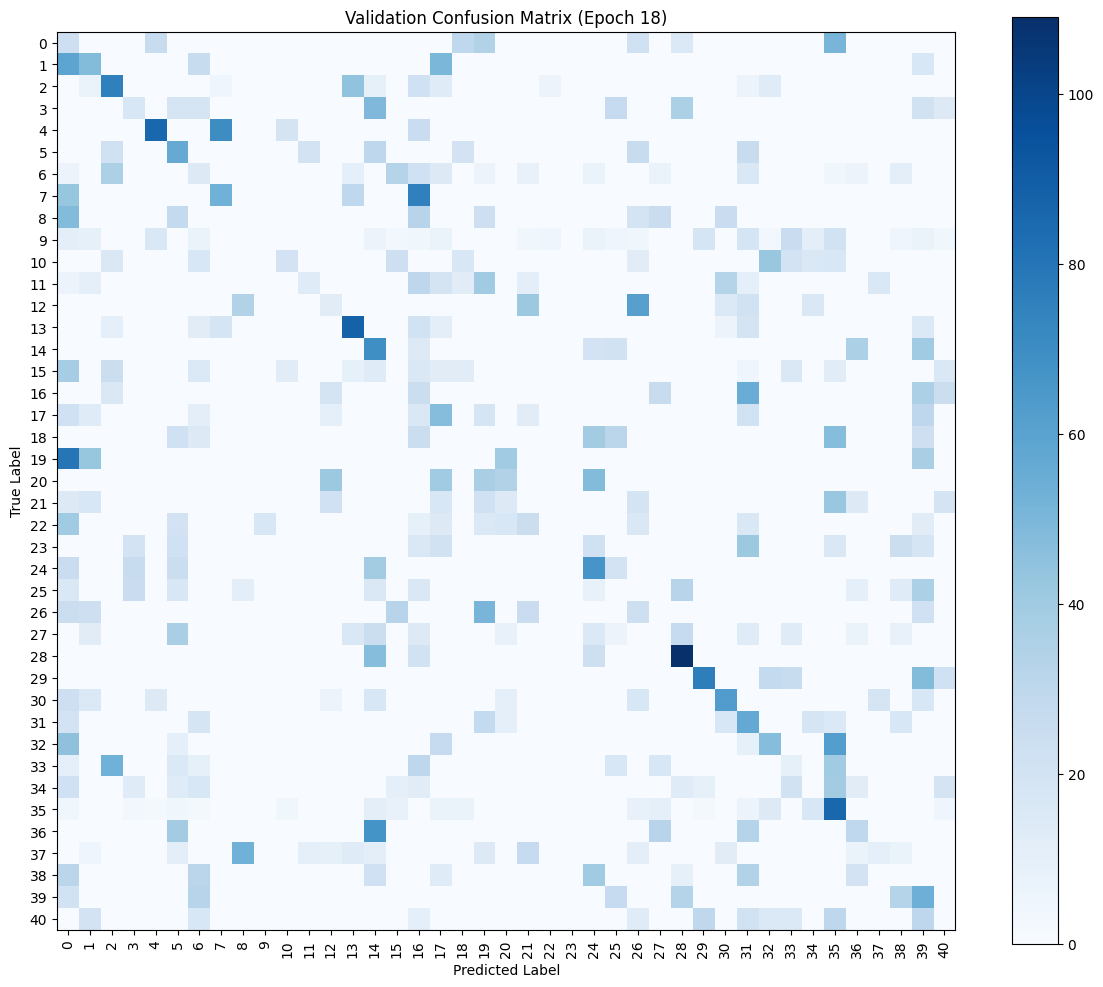

Val Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]



Epoch 19 Summary:
  Train Loss: 2.1300, Train Acc: 0.5165
  Val   Loss: 3.2497, Val   Acc: 0.1435


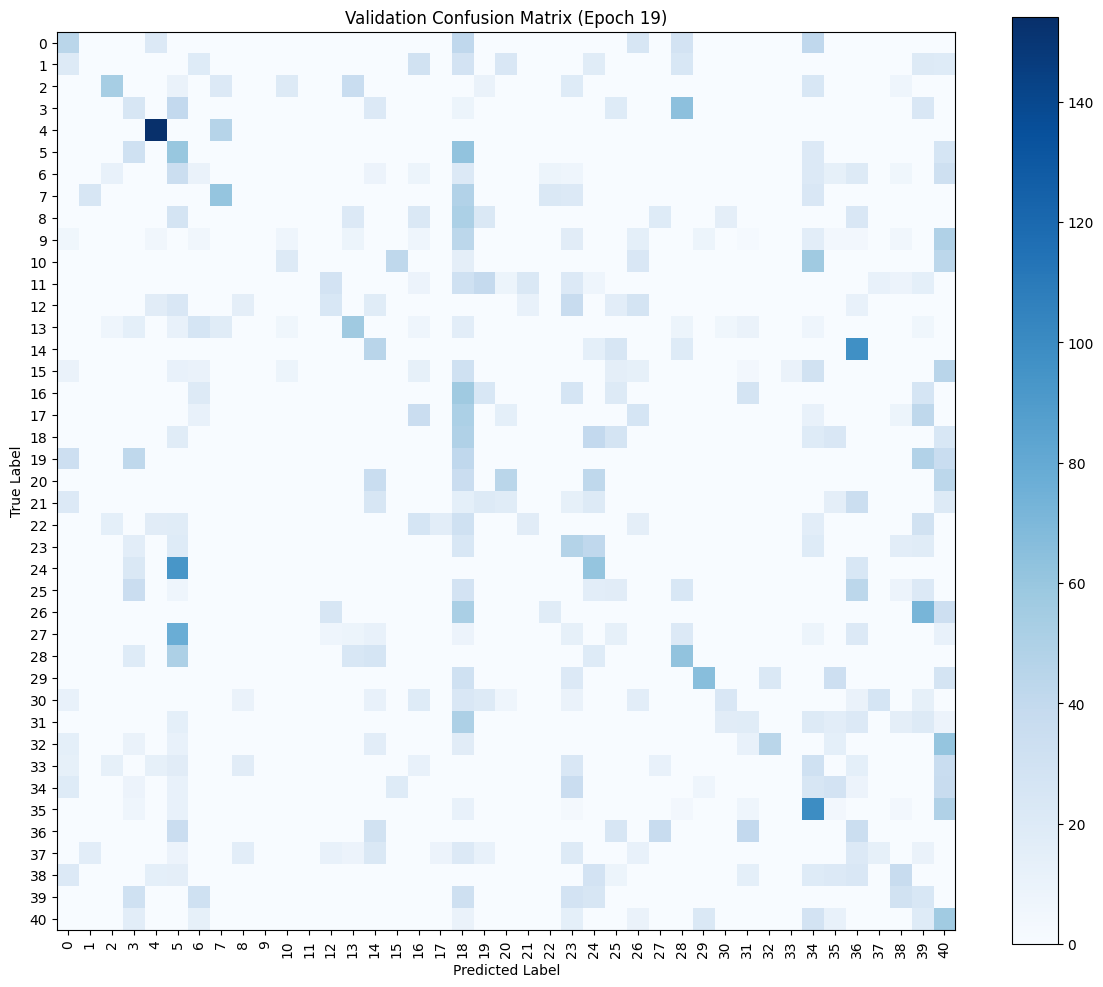

Val Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]



Epoch 20 Summary:
  Train Loss: 2.0866, Train Acc: 0.5187
  Val   Loss: 3.1523, Val   Acc: 0.1504


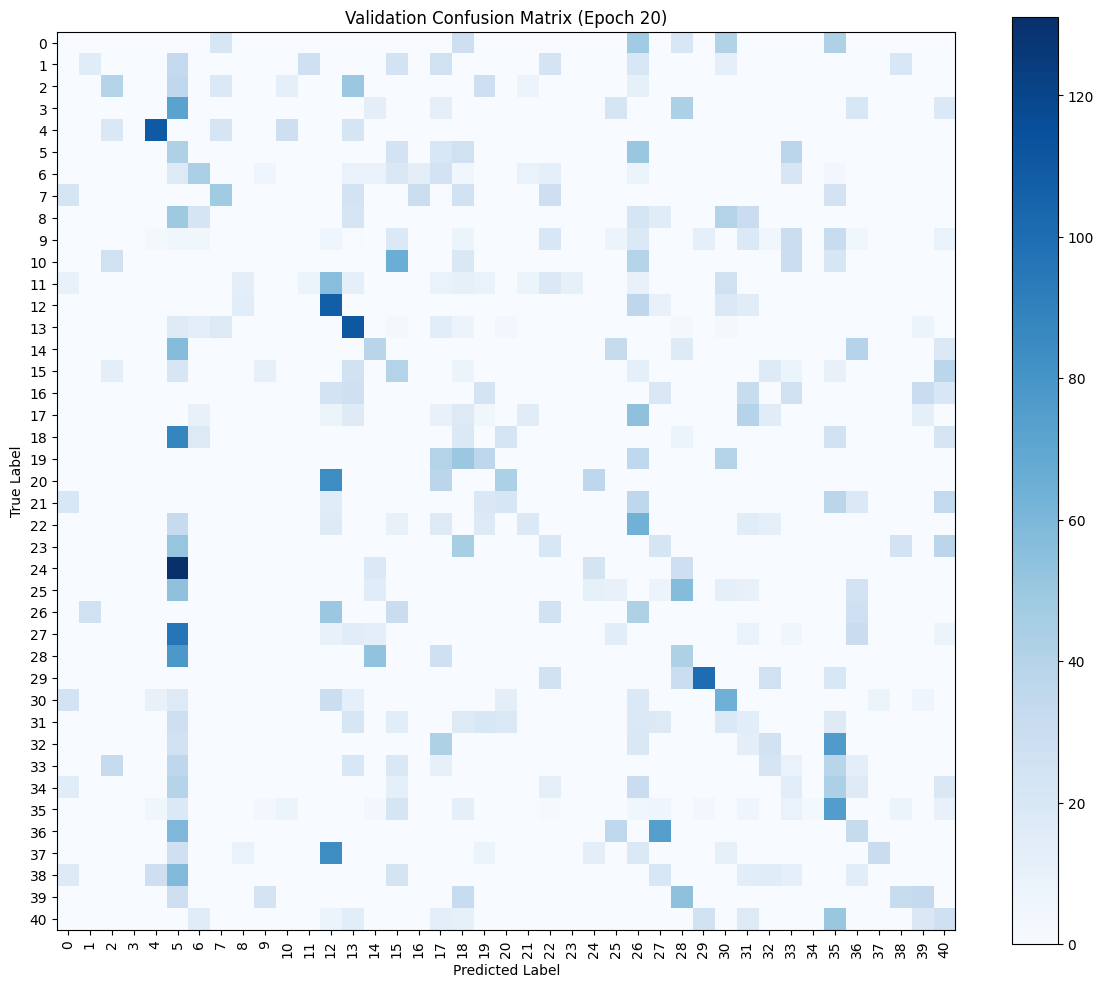


  Per-class Training Accuracy:
    Class 00: 0.6275 (251/400)
    Class 01: 0.5275 (211/400)
    Class 02: 0.5075 (203/400)
    Class 03: 0.6000 (240/400)
    Class 04: 0.8950 (358/400)
    Class 05: 0.7450 (298/400)
    Class 06: 0.2875 (115/400)
    Class 07: 0.9275 (371/400)
    Class 08: 0.6200 (248/400)
    Class 09: 0.1025 (41/400)
    Class 10: 0.5725 (229/400)
    Class 11: 0.3225 (129/400)
    Class 12: 0.6725 (269/400)
    Class 13: 0.6600 (264/400)
    Class 14: 0.7175 (287/400)
    Class 15: 0.1800 (72/400)
    Class 16: 0.5650 (226/400)
    Class 17: 0.1375 (55/400)
    Class 18: 0.4775 (191/400)
    Class 19: 0.5300 (212/400)
    Class 20: 1.0000 (400/400)
    Class 21: 0.4900 (196/400)
    Class 22: 0.1025 (41/400)
    Class 23: 0.4550 (182/400)
    Class 24: 0.7475 (299/400)
    Class 25: 0.4150 (166/400)
    Class 26: 0.6975 (279/400)
    Class 27: 0.1400 (56/400)
    Class 28: 0.6425 (257/400)
    Class 29: 0.7475 (299/400)
    Class 30: 0.4275 (171/400)
    Class 31

In [19]:
# --- Define model with learnable prototypes ---
class ProtoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=41, embedding_dim=32):
        super().__init__()
        self.backbone = backbone
        # prototypes are learnable parameters
        self.class_prototypes = nn.Parameter(
            torch.randn(num_classes, embedding_dim)
        )

    def forward(self, x):
        embeddings = self.backbone(x)  # (B, embedding_dim)
        dists = torch.cdist(embeddings, self.class_prototypes)  # (B, num_classes)
        logits = -dists
        return logits, embeddings


# --- Setup ---
num_classes = 41
embedding_dim = 32
model = ProtoClassifier(ProtoNet(embedding_dim), num_classes, embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training + Validation Loop ---
for epoch in range(1, 21):
    # --- Train ---
    model.train()
    train_loss, train_acc = 0.0, 0.0
    train_class_correct = defaultdict(int)
    train_class_total = defaultdict(int)

    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, _ = model(images)

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        train_loss += loss.item()
        train_acc += (preds == labels).float().mean().item()

        # track per-class
        for t, p in zip(labels, preds):
            train_class_total[t.item()] += 1
            if t == p:
                train_class_correct[t.item()] += 1

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # --- Validate ---
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    val_class_correct = defaultdict(int)
    val_class_total = defaultdict(int)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
            images, labels = images.to(device), labels.to(device)

            logits, _ = model(images)
            loss = F.cross_entropy(logits, labels)

            preds = logits.argmax(dim=1)
            val_loss += loss.item()
            val_acc += (preds == labels).float().mean().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # track per-class
            for t, p in zip(labels, preds):
                val_class_total[t.item()] += 1
                if t == p:
                    val_class_correct[t.item()] += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # --- Summary ---
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    print(f"  Val   Loss: {avg_val_loss:.4f}, Val   Acc: {avg_val_acc:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Validation Confusion Matrix (Epoch {epoch})")
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, tick_marks, rotation=90)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # --- Per-class Accuracy (every 10th epoch) ---
    if epoch % 10 == 0:
        print("\n  Per-class Training Accuracy:")
        for cls in range(num_classes):
            if train_class_total[cls] > 0:
                acc_cls = train_class_correct[cls] / train_class_total[cls]
                print(f"    Class {cls:02d}: {acc_cls:.4f} "
                      f"({train_class_correct[cls]}/{train_class_total[cls]})")
            else:
                print(f"    Class {cls:02d}: N/A")

        print("\n  Per-class Validation Accuracy:")
        for cls in range(num_classes):
            if val_class_total[cls] > 0:
                acc_cls = val_class_correct[cls] / val_class_total[cls]
                print(f"    Class {cls:02d}: {acc_cls:.4f} "
                      f"({val_class_correct[cls]}/{val_class_total[cls]})")
            else:
                print(f"    Class {cls:02d}: N/A")

In [20]:
torch.save(model.state_dict(), 'model_weights.pth')

In [21]:
# get unique labels
unique_labels = sorted(set(train_labels))

# extract folder names (class names)
class_to_name = {}
for path, label in train_files:
    class_name = os.path.basename(os.path.dirname(path))
    class_to_name[label] = class_name

# now you have
class_names = [class_to_name[i] for i in range(len(class_to_name))]

In [22]:
class_names

['Alambadi',
 'Amritmahal',
 'Ayrshire',
 'Banni',
 'Bargur',
 'Bhadawari',
 'Brown_Swiss',
 'Dangi',
 'Deoni',
 'Gir',
 'Guernsey',
 'Hallikar',
 'Hariana',
 'Holstein_Friesian',
 'Jaffrabadi',
 'Jersey',
 'Kangayam',
 'Kankrej',
 'Kasargod',
 'Kenkatha',
 'Kherigarh',
 'Khillari',
 'Krishna_Valley',
 'Malnad_gidda',
 'Mehsana',
 'Murrah',
 'Nagori',
 'Nagpuri',
 'Nili_Ravi',
 'Nimari',
 'Ongole',
 'Pulikulam',
 'Rathi',
 'Red_Dane',
 'Red_Sindhi',
 'Sahiwal',
 'Surti',
 'Tharparkar',
 'Toda',
 'Umblachery',
 'Vechur']